# Uso de estimadores con Tensorflow
(por: Javier Arellano-Verdejo)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
plt.style.use("seaborn-colorblind")

%matplotlib inline

tf.logging.set_verbosity(tf.logging.FATAL)

### 1. Carga de los datos

In [13]:
used_features = ['property_type','room_type','bathrooms','bedrooms','beds','bed_type','accommodates','host_total_listings_count'
                ,'number_of_reviews','review_scores_value','neighbourhood_cleansed','cleaning_fee','minimum_nights','security_deposit','host_is_superhost',
                 'instant_bookable', 'price']

airbnb = pd.read_csv('./data/listings.csv', usecols = used_features)
print(airbnb.shape)
airbnb.head(2)

(3585, 17)


,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,$250.00,NaN,$35.00,2,0,NaN,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,$65.00,$95.00,$10.00,2,36,9.0,t


### 2. Preprocesamiento de los datos

* Las columnas **price**, **security_deposit** and **cleaning_fee** contienen datos que representan números sin embargo contienen algunos caracteres ($ y ,). Estos caracteres deben ser eliminados y finalmente los numeros deben ser convertidos a flotantes.

* Por otro lado, otras columnas como **bathroom** y **bed** contienen datos faltantes por lo que deben ser rellenados usando por ejemplo la media.

* Finalmente, la columna **property_type** es de tipo categorico por lo que los datos faltantes serán rellenados usando el dato que más se repita.


In [14]:
# elimino los caracteres $ y , y convierto los datos a tipo flotante

for feature in ["cleaning_fee","security_deposit","price"]:
    airbnb[feature] = airbnb[feature].map(lambda x:x.replace("$",'').replace(",",''),na_action = 'ignore')
    airbnb[feature] = airbnb[feature].astype(float)
    airbnb[feature].fillna(airbnb[feature].median(),inplace = True)

# relleno los datos faltantes   
for feature in ["bathrooms","bedrooms","beds","review_scores_value"]:
    airbnb[feature].fillna(airbnb[feature].median(),inplace = True)

# relleno los datos categóricos 
airbnb['property_type'].fillna('Apartment',inplace = True)

Veamos los cambios en los datos

In [15]:
airbnb.head(2)

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,250.0,35.0,2,0,9.0,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,65.0,95.0,10.0,2,36,9.0,t


Observemos la columna de precio

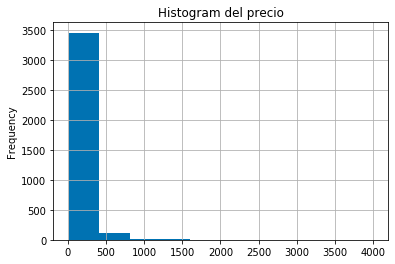

In [16]:
airbnb["price"].plot(kind = 'hist',grid = True)
plt.title("Histogram del precio");

Como se puede observar, los datos se encuentran altamense sesgados en este set de datos es decir, la mayoria se encuentran por debajo de los 500 dolares y solo muy pocos en torno a los 4000

In [17]:
airbnb['price'].skew()

8.521483565683951

Debido a este sesgo, solo usaremos un subconjunto de los datos usando solo aquellos com precios comprendidos entre los 50 y los 500 dolares, tambien transformaremos la escala de la información a logaritmica para reducir dicho sesgo

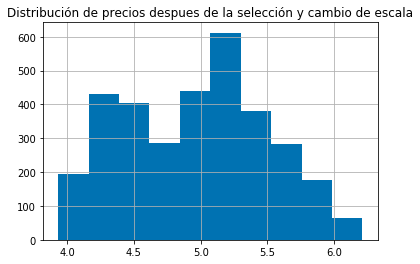

In [18]:
airbnb = airbnb[(airbnb["price"]>50)&(airbnb["price"]<500)]
target = np.log(airbnb.price) # columna objetivo durante el proceso de entrenamiento

target.hist()
plt.title("Distribución de precios despues de la selección y cambio de escala");

Elimino la columna de precio del conjunto de datos para quedarme solo con las columnas de carcateristicas

In [19]:
features = airbnb.drop('price',axis=1)
features.head(2)

,host_is_superhost,host_total_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,security_deposit,cleaning_fee,minimum_nights,number_of_reviews,review_scores_value,instant_bookable
0,f,1,Roslindale,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,250.0,35.0,2,0,9.0,f
1,f,1,Roslindale,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,95.0,10.0,2,36,9.0,t


### 3. Divido los datos en los conjuntos de entrenamiento y prueba

El conjunto de datos total es dividido en datos para prueba y datos para entrenamiento. El 30 porciento de los datos serán usados para prueba mientras que el otro 70 será usado para el entrenamiento del modelo. La opción *random_state* del método **train_test_split**, es utilizada para obtener siempre el mismo resultado, es decir inicializa el generador aleatorio para asi poder reproducir el ejemplo. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.30, 
    random_state=42
)

### 4. Definición de las columnas de caracteristicas "Feature Columns"

In [21]:
# Get all the numeric feature names
numeric_columns = ['host_total_listings_count','accommodates','bathrooms','bedrooms','beds',
 'security_deposit','cleaning_fee','minimum_nights','number_of_reviews',
 'review_scores_value']

# Get all the categorical feature names that contains strings
categorical_columns = ['host_is_superhost','neighbourhood_cleansed','property_type','room_type','bed_type','instant_bookable']


Creacion de las columnas de caracteristicas para los atributos numéricos

In [22]:
numeric_features = [tf.feature_column.numeric_column(key = column) for column in numeric_columns]

print(numeric_features[0])

NumericColumn(key='host_total_listings_count', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


Creaciónde las columnas de caracteristicas para los atributos categoricos

In [23]:
categorical_features = [tf.feature_column.categorical_column_with_vocabulary_list(
    key = column, vocabulary_list = features[column].unique())  for column in categorical_columns]

print(categorical_features[3])

VocabularyListCategoricalColumn(key='room_type', vocabulary_list=('Entire home/apt', 'Private room', 'Shared room'), dtype=tf.string, default_value=-1, num_oov_buckets=0)


Creamos la lista final de atributos

In [24]:
linear_features = numeric_features + categorical_features

### 5. Construcción de las funciones de entrada

In [25]:
# Create training input function
training_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_train,
                                                        y=y_train,
                                                        batch_size=32,
                                                        shuffle= True,
                                                        num_epochs = None)
# create testing input function
eval_input_fn = tf.estimator.inputs.pandas_input_fn(x=X_test,
                                                    y=y_test,
                                                    batch_size=32,
                                                    shuffle=False,
                                                    num_epochs = 1)

### 6. Inicializamos el modelo

In [26]:
linear_regressor = tf.estimator.LinearRegressor(feature_columns=linear_features,
                                                model_dir = "linear_regressor")

### 7. Entrenamiento del modelo

In [27]:
linear_regressor.train(input_fn = training_input_fn,steps=2000)

### 8. Evaluación del modelo

In [28]:
linear_regressor.evaluate(input_fn = eval_input_fn)

{'average_loss': 0.1241837,
 'label/mean': 4.9814363,
 'loss': 3.9298131,
 'prediction/mean': 4.9753585,
 'global_step': 4000}

In [29]:
pred = list(linear_regressor.predict(input_fn = eval_input_fn))
pred = [p['predictions'][0] for p in pred]
prices = np.exp(pred)
print(prices)

[ 88.58753   91.42419   88.03337  135.52568  148.45294  202.88943
 241.30313  332.2077    83.58202   82.43143  247.31906   86.48483
 264.7164   342.68887  162.82704  250.24536   86.75831  167.91437
 241.13037   67.81129  187.36203  186.22282   78.644585  62.66999
 135.71677   94.85768   87.09388  216.65897  185.48877  110.51609
 176.59503   73.16732   86.60153  141.24295   82.02714  104.865395
 171.25949   86.68714  221.39735  253.08955  225.33705  197.48642
 143.12071  101.13213  160.9279    60.254974  76.48476  182.03012
 120.34486  118.87141  100.700584 238.69995  193.49878  213.85327
 222.2553    43.652596 112.63952   77.370575 216.69781   80.48579
 168.45859   73.068794 247.6672   364.08923  392.08698  186.22282
 114.90901  425.9497   124.860794  83.46835  189.87329  137.43315
  85.311935 104.896645  85.53299  173.01437  148.24998   82.81915
 188.8943   192.98976   77.99752  153.43376  292.14517   85.6195
 164.4168   104.84214  208.98326  134.17227  144.05008  341.94275
  92.63557

In [30]:
# Calculamos el error cuadratico medio de las predicciones contra los valores reales

np.sqrt(np.sum(np.exp(y_test).values - prices)**2) / prices.shape[0]

3.1669501675013634

In [31]:
# muestro los valors reales
np.exp(y_test.values)

array([ 67.,  90.,  75., 150., 195., 169., 319., 210.,  60.,  75., 200.,
        89., 279., 119., 160., 250.,  81., 160., 300.,  60., 199., 169.,
        60.,  79., 135.,  65.,  77., 200., 225., 165., 300., 200.,  80.,
       272.,  75.,  90., 265., 119., 275., 220., 251., 175., 190.,  80.,
       215.,  75.,  88., 300., 150., 185.,  80., 169., 175., 218., 275.,
        70.,  65., 100., 200., 220., 140.,  89., 250., 279., 319., 169.,
       160., 319., 119., 100., 287., 207.,  60.,  95.,  75., 145., 106.,
        72., 225., 185.,  75., 105., 250.,  75., 200.,  75., 160., 100.,
       300., 199.,  64., 119., 115.,  70., 125.,  60.,  99., 149.,  60.,
       275.,  99., 150., 188., 250.,  75., 250., 299., 199., 169.,  99.,
       235., 110., 207.,  68., 250., 289., 170., 175., 107.,  65., 400.,
       119., 145., 135.,  65.,  80., 199.,  65., 249., 150.,  99.,  59.,
        65., 240.,  90., 375., 259., 100., 130., 175.,  97., 330., 200.,
       295., 299., 195., 175.,  67.,  72., 200., 19